In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#LIGNIN-KMC Package
import ligninkmc as kmc
import ligninkmc.Analysis

#General Math and LinAlg
import numpy as np
import scipy as sp
import scipy.optimize

#Chemical Drawing
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG

#Plotting
import matplotlib.pyplot as plt

#Profiling and Performance
import cProfile
import time

#Parallelization
import joblib as par

In [3]:
kb = 1.38064852e-23 # J / K
h = 6.62607004e-34 # J s
temp = 298.15 #K
kcalToJoule = 4184 / 6.022140857e23

#Input energy information
#Select which energy set you want to use
energies = {'5o4':{(0,0):{('monomer','monomer'):11.2,('monomer','dimer'):14.6,
                          ('dimer','monomer'):14.6,('dimer','dimer'):4.4},
                   (1,0):{('monomer','monomer'):10.9,('monomer','dimer'):14.6,
                          ('dimer','monomer'):14.6,('dimer','dimer'):4.4}},
            '55':{(0,0):{('monomer','monomer'):12.5,('monomer','dimer'):15.6,
                          ('dimer','monomer'):15.6,('dimer','dimer'):3.8}},
            'b5':{(0,0):{('monomer','monomer'):5.5,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8},
                  (0,1):{('monomer','monomer'):5.5,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8}},
            'bb':{(0,0):{('monomer','monomer'):5.2,('monomer','dimer'):5.2,('dimer','monomer'):5.2,('dimer','dimer'):5.2},
                  (1,0):{('monomer','monomer'):6.5,('monomer','dimer'):6.5,('dimer','monomer'):6.5,('dimer','dimer'):6.5},
                  (1,1):{('monomer','monomer'):5.2,('monomer','dimer'):5.2,('dimer','monomer'):5.2,('dimer','dimer'):5.2}},
            'bo4':{(0,0):{('monomer','monomer'):6.3,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (1,0):{('monomer','monomer'):9.1,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (0,1):{('monomer','monomer'):8.9,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (1,1):{('monomer','monomer'):9.8,('monomer','dimer'):10.4,
                          ('dimer','monomer'):10.4}},
            'ao4':{(0,0):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (1,0):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (0,1):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (1,1):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7}},
            'b1':{(0,0):{('monomer','dimer'):9.6,
                          ('dimer','monomer'):9.6,('dimer','dimer'):9.6},
                  (1,0):{('monomer','dimer'):11.7,
                          ('dimer','monomer'):11.7,('dimer','dimer'):11.7},
                  (0,1):{('monomer','dimer'):10.7,
                          ('dimer','monomer'):10.7,('dimer','dimer'):10.7},
                  (1,1):{('monomer','dimer'):11.9,
                          ('dimer','monomer'):11.9,('dimer','dimer'):11.9}},
            'ox':{0:{'monomer':0.9,'dimer':6.3},1:{'monomer':0.6,'dimer':2.2}},
            'q':{0:{'monomer':11.1,'dimer':11.1},1:{'monomer':11.7,'dimer':11.7}}}
energies['bb'][(0,1)] = energies['bb'][(1,0)]

#Correct units of the energies
energiesev = {bond : {monType : {size : energies[bond][monType][size] * kcalToJoule for size in energies[bond][monType]}
                    for monType in energies[bond] } 
            for bond in energies }

#Calculate the rates of reaction
rates = {bond : {monType : { size : kb * temp / h * np.exp ( - energiesev[bond][monType][size] / kb / temp ) 
                            for size in energies[bond][monType]} 
                 for monType in energies[bond] } #Make rates 1/ns instead of 1/s
         for bond in energies}

In [4]:
sg = 1
#Set the percentage of S
pct = sg / (1 + sg)
fun = par.delayed(kmc.run_kmc)
#Make choices about what kinds of monomers there are
n = 200
rands = np.random.rand(n)

#Initialize the monomers, events, and state
mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
events = { startEvents[i] for i in range(n) }
#events.add(kmc.Event('grow',[],rate = 1e14,bond = sg))

results = par.Parallel(n_jobs = 8,verbose = 11)([fun(nMax = 200, tFinal = 10000,rates = rates,initialState = state,initialEvents = events,dynamics = True)
                                    for _ in range(8)])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.2min remaining:  9.5min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  3.2min remaining:  5.4min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  3.3min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.3min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  3.4min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.5min finished


In [5]:
def getTraces(result):
    t = result['time']
    mons = result['monomers']
    adjs = result['adjacency_matrix']
    bcounts = [] #List of dicts
    fcounts = [] #List of counters
    for mon,adj in zip(mons,adjs):
        bonds = kmc.Analysis.count_bonds(adj=adj)
        frags = kmc.Analysis.count_oligomer_yields(adj=adj)
        
        bcounts.append(bonds)
        fcounts.append(frags)
        
    bcounts = {key : [count[key] for count in bcounts] for key in ['bo4','bb','b5','b1','5o4','ao4','55']}
    fcounts = {length : [count[length]*length for count in fcounts] for length in range(1,6)}
    return { 'time' : t , 'bond counts' : bcounts , 'frag lengths' : fcounts}

In [6]:
output = par.Parallel(n_jobs = 8,verbose = 11)([par.delayed(getTraces)(res) for res in results])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  3.9min
/Users/hmayes/miniconda3/envs/lignin_kmc/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  5.2min remaining: 15.6min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  5.7min remaining:  9.6min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  6.8min remaining:  6.8min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  7.6min remaining:  4.6min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  8.2min remaining:  2.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  9.9min finished


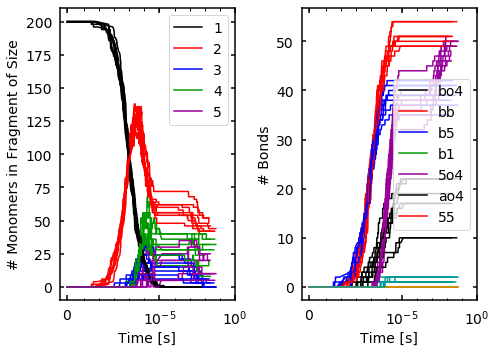

In [7]:
fig,axes = plt.subplots(1,2,figsize=(7,5))
for out in output:
    t = out['time']
    bcount = out['bond counts']
    fcount = out['frag lengths']
    [axes[0].plot(t,fcount[i],linestyle = '-',color = style,label=i) for (i,style) 
     in zip(fcount,[(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),(0.6,0,0),(0,0,0.6)])]
    [axes[1].plot(t,bcount[i],linestyle = '-',color = style,label=i) for (i,style) 
     in zip(bcount,[(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),(0.6,0,0),(0,0,0.6)])]
    
axes[0].set_xscale('symlog',linthreshx=1e-10)
axes[0].legend(axes[0].get_children()[:5],['1','2','3','4','5'],loc='best',fontsize=14)
[axes[0].spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
axes[0].tick_params(axis = 'x',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=5)
axes[0].tick_params(axis = 'x',which = 'minor', labelsize = 8, direction = 'in', pad = 8, top = True, right = True, width = 1,length=2.5)
axes[0].tick_params(axis = 'y',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=4)
axes[0].set_xticks([0, 1e-5, 1])
axes[0].set_xlabel('Time [s]',fontsize=14)
axes[0].set_ylabel('# Monomers in Fragment of Size',fontsize=14)

axes[1].set_xscale('symlog',linthreshx=1e-10)
axes[1].legend(axes[0].get_children()[:7],['bo4','bb','b5','b1','5o4','ao4','55'],loc='best',fontsize=14)
[axes[1].spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
axes[1].tick_params(axis = 'x',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=5)
axes[1].tick_params(axis = 'x',which = 'minor', labelsize = 8, direction = 'in', pad = 8, top = True, right = True, width = 1,length=2.5)
axes[1].tick_params(axis = 'y',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=4)
axes[1].set_xticks([0, 1e-5, 1])
axes[1].set_xlabel('Time [s]',fontsize=14)
axes[1].set_ylabel('# Bonds',fontsize=14)

fig.tight_layout()

In [8]:
sg = 1
#Set the percentage of S
pct = sg / (1 + sg)
fun = par.delayed(kmc.run_kmc)
#Make choices about what kinds of monomers there are
n = 2
rands = np.random.rand(n)

#Initialize the monomers, events, and state
mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
events = { startEvents[i] for i in range(n) }
events.add(kmc.Event('grow',[],rate = 1,bond = sg))

results = par.Parallel(n_jobs = 8,verbose = 11)([fun(nMax = 200, tFinal = 10000,rates = rates,initialState = state,initialEvents = events,dynamics = True)
                                    for _ in range(8)])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   54.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   58.6s remaining:  2.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.8s remaining:  1.7min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.1min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.1min remaining:   22.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.2min finished


In [9]:
output = par.Parallel(n_jobs = 8,verbose = 11)([par.delayed(getTraces)(res) for res in results])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  5.3min remaining: 15.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  5.3min remaining:  8.9min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  6.2min remaining:  6.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  7.1min remaining:  4.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  7.8min remaining:  2.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  9.8min finished


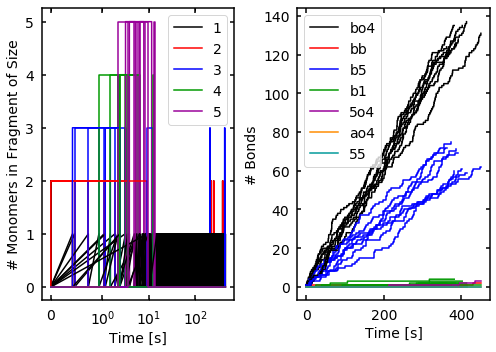

In [10]:
fig,axes = plt.subplots(1,2,figsize=(7,5))
for out in output:
    t = out['time']
    bcount = out['bond counts']
    fcount = out['frag lengths']
    [axes[0].plot(t,fcount[i],linestyle = '-',color = style,label=i) for (i,style) 
     in zip(fcount,[(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),(0.6,0,0),(0,0,0.6)])]
    lines = [axes[1].plot(t,bcount[i],linestyle = '-',color = style,label=i) for (i,style) 
     in zip(bcount,[(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),(0.6,0,0),(0,0,0.6)])]
    
axes[0].set_xscale('symlog',linthreshx=1)
axes[0].legend(axes[0].get_children()[:5],['1','2','3','4','5'],loc='best',fontsize=14)
[axes[0].spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
axes[0].tick_params(axis = 'x',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=5)
axes[0].tick_params(axis = 'x',which = 'minor', labelsize = 8, direction = 'in', pad = 8, top = True, right = True, width = 1,length=2.5)
axes[0].tick_params(axis = 'y',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=4)
#axes[0].set_xticks([0, 1, 10, 100])
axes[0].set_xlabel('Time [s]',fontsize=14)
axes[0].set_ylabel('# Monomers in Fragment of Size',fontsize=14)

#axes[1].set_xscale('symlog',linthreshx=1e-10)
axes[1].legend(axes[1].get_children()[:7],['bo4','bb','b5','b1','5o4','ao4','55'],loc='best',fontsize=14)
[axes[1].spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
axes[1].tick_params(axis = 'x',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=5)
axes[1].tick_params(axis = 'x',which = 'minor', labelsize = 8, direction = 'in', pad = 8, top = True, right = True, width = 1,length=2.5)
axes[1].tick_params(axis = 'y',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=4)
#axes[1].set_xticks([0, 1e-5, 1])
axes[1].set_xlabel('Time [s]',fontsize=14)
axes[1].set_ylabel('# Bonds',fontsize=14)

fig.tight_layout()

In [11]:
sg = 1
#Set the percentage of S
pct = sg / (1 + sg)
fun = par.delayed(kmc.run_kmc)
#Make choices about what kinds of monomers there are
n = 2
rands = np.random.rand(n)

#Initialize the monomers, events, and state
mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
events = { startEvents[i] for i in range(n) }
events.add(kmc.Event('grow',[],rate = 1e5,bond = sg))

results = par.Parallel(n_jobs = 8,verbose = 11)([fun(nMax = 200, tFinal = 10000,rates = rates,initialState = state,initialEvents = events,dynamics = True)
                                    for _ in range(8)])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.4min remaining:  4.2min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.5min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.6min remaining:   58.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.7min remaining:   33.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


In [12]:
output = par.Parallel(n_jobs = 8,verbose = 11)([par.delayed(getTraces)(res) for res in results])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  5.0min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  6.3min remaining: 18.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  7.5min remaining: 12.5min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 21.7min remaining: 21.7min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 22.1min remaining: 13.3min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 22.6min remaining:  7.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 23.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 23.5min finished


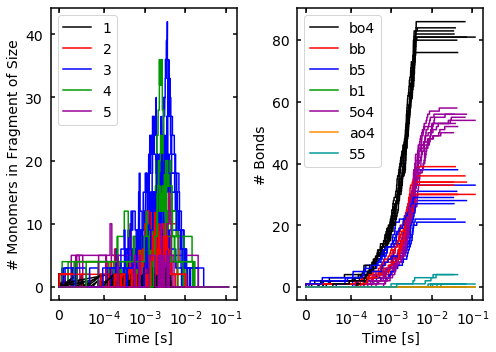

In [13]:
fig,axes = plt.subplots(1,2,figsize=(7,5))
for out in output:
    t = out['time']
    bcount = out['bond counts']
    fcount = out['frag lengths']
    [axes[0].plot(t,fcount[i],linestyle = '-',color = style,label=i) for (i,style) 
     in zip(fcount,[(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),(0.6,0,0),(0,0,0.6)])]
    lines = [axes[1].plot(t,bcount[i],linestyle = '-',color = style,label=i) for (i,style) 
     in zip(bcount,[(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),(0.6,0,0),(0,0,0.6)])]
    
axes[0].set_xscale('symlog',linthreshx=1e-4)
axes[0].legend(axes[0].get_children()[:5],['1','2','3','4','5'],loc='best',fontsize=14)
[axes[0].spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
axes[0].tick_params(axis = 'x',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=5)
axes[0].tick_params(axis = 'x',which = 'minor', labelsize = 8, direction = 'in', pad = 8, top = True, right = True, width = 1,length=2.5)
axes[0].tick_params(axis = 'y',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=4)
#axes[0].set_xticks([0, 1e-5, 1])
axes[0].set_xlabel('Time [s]',fontsize=14)
axes[0].set_ylabel('# Monomers in Fragment of Size',fontsize=14)

axes[1].set_xscale('symlog',linthreshx=1e-4)
axes[1].legend(axes[1].get_children()[:7],['bo4','bb','b5','b1','5o4','ao4','55'],loc='best',fontsize=14)
[axes[1].spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
axes[1].tick_params(axis = 'x',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=5)
axes[1].tick_params(axis = 'x',which = 'minor', labelsize = 8, direction = 'in', pad = 8, top = True, right = True, width = 1,length=2.5)
axes[1].tick_params(axis = 'y',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=4)
#axes[1].set_xticks([0, 1e-5, 1])
axes[1].set_xlabel('Time [s]',fontsize=14)
axes[1].set_ylabel('# Bonds',fontsize=14)

fig.tight_layout()